<a href="https://colab.research.google.com/github/kovalenko07112003/Machine-Learning_Kovalenko-ALexandr/blob/main/7practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
df = pd.read_csv('C:/Users/Александр/Python/myenv/Lib/site-packages/parso/python/transaction.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Александр/Python/myenv/Lib/site-packages/parso/python/transaction.csv'

In [ ]:
def aggregate_client_daily_items(df):
     # Приведём названия столбцов к единому стандарту на случай разного написания
    column_mapping = {
        'clientID': 'client',
        'trDte': 'visit_date',
        'itemGroup': 'item_group',
        'itemgroup': 'item_group',
        'ItemGroup': 'item_group'
    }

    # Проверим, какие столбцы есть в df, и переименуем только существующие
    actual_mapping = {k: v for k, v in column_mapping.items() if k in df.columns}
    df_clean = df.rename(columns=actual_mapping)

    # Проверка обязательных колонок
    required = ['client', 'visit_date', 'item', 'item_group', 'quantity', 'amount']
    missing = [col for col in required if col not in df_clean.columns]
    if missing:
        raise ValueError(f"Отсутствуют необходимые столбцы: {missing}")

    # Группировка по (client, visit_date, item, item_group)
    grouped = (
        df_clean
        .groupby(['client', 'visit_date', 'item', 'item_group'], as_index=False)
        .agg({
            'quantity': 'sum',
            'amount': 'sum'
        })
    )

    # Сортировка
    result = grouped.sort_values(by=['client', 'visit_date', 'item']).reset_index(drop=True)

    return result

In [ ]:
visits_df = aggregate_client_daily_items(df)
visits_df

In [ ]:
def calculate_client_profile_at_date(visits_df, observation_end_date):
    # Приведение типов
    observation_end_date = pd.to_datetime(observation_end_date)
    visits_df = visits_df.copy()
    visits_df['visit_date'] = pd.to_datetime(visits_df['visit_date'])

    # 1. Фильтрация: только визиты ДО observation_end_date (важно! нет утечки)
    filtered_visits = visits_df[visits_df['visit_date'] < observation_end_date].copy()

    if filtered_visits.empty:
        return pd.DataFrame(columns=[
            'client', 'Recency', 'Frequency', 'Monetary',
            'last_visit_date', 'total_quantity', 'avg_check',
            'total_unique_items', 'avg_items_per_visit',
            'weekend_visits', 'amount_last_visit'
        ])

    # Преобразуем дату в день (удаляем время, если есть)
    filtered_visits['visit_date'] = filtered_visits['visit_date'].dt.date
    observation_date = observation_end_date.date()

    # Группировка по клиенту
    grouped = filtered_visits.groupby('client')

    # Подготовка данных по клиентам
    profiles = []

    for client_id, group in grouped:
        visit_dates = pd.to_datetime(group['visit_date'])  # для вычислений
        last_date = visit_dates.max().date()
        recency = (observation_date - last_date).days

        frequency = group['visit_date'].nunique()  # уникальные даты визитов
        monetary = group['amount'].sum()
        total_quantity = group['quantity'].sum()
        avg_check = monetary / frequency if frequency > 0 else 0
        total_unique_items = group['item'].nunique()
        avg_items_per_visit = total_quantity / frequency

        # Количество визитов в выходные (суббота=5, воскресенье=6)
        visit_weekdays = pd.to_datetime(group['visit_date']).dt.weekday
        weekend_visits = visit_weekdays.isin([5, 6]).sum()

        # Сумма последнего визита
        last_visit_data = group[group['visit_date'] == last_date]
        amount_last_visit = last_visit_data['amount'].sum()

        profiles.append({
            'client': client_id,
            'Recency': recency,
            'Frequency': frequency,
            'Monetary': monetary,
            'last_visit_date': last_date,
            'total_quantity': total_quantity,
            'avg_check': round(avg_check, 2),
            'total_unique_items': total_unique_items,
            'avg_items_per_visit': round(avg_items_per_visit, 2),
            'weekend_visits': weekend_visits,
            'amount_last_visit': amount_last_visit
        })

    # Создаём DataFrame
    result_df = pd.DataFrame(profiles)

    # Сортировка
    result_df = result_df.sort_values(by='client').reset_index(drop=True)

    print(f"✅ Профили рассчитаны: {len(result_df)} клиентов на дату {observation_end_date.date()}")
    return result_df



In [ ]:
# Рассчитываем профиль на 2019-09-01
profile_df = calculate_client_profile_at_date(visits_df, '2019-09-01')

print(profile_df.head())

In [ ]:
def mark_events(visits_df, result_start_date, result_end_date):
      # Приведение типов
    result_start = pd.to_datetime(result_start_date)
    result_end = pd.to_datetime(result_end_date)
    visits = visits_df.copy()
    visits['visit_date'] = pd.to_datetime(visits['visit_date'])

    # 1. Получить всех уникальных клиентов
    all_clients = pd.DataFrame({'client': visits['client'].unique()})
    all_clients = all_clients.sort_values('client').reset_index(drop=True)

    # 2. Фильтрация визитов в период [result_start, result_end)
    event_visits = visits[
        (visits['visit_date'] >= result_start) &
        (visits['visit_date'] < result_end)
    ]

    # 3. Определяем клиентов, которые посетили в этот период
    clients_with_visit = event_visits['client'].unique()

    # 4. Добавляем флаг event
    all_clients['event'] = all_clients['client'].isin(clients_with_visit)

    print(f"✅ Разметка событий завершена:")
    print(f"   Всего клиентов: {len(all_clients)}")
    print(f"   Вернулись в период [{result_start.date()} — {result_end.date()}): {all_clients['event'].sum()} ({all_clients['event'].mean():.1%})")

    return all_clients

In [ ]:
# Размечаем событие: [2019-09-01, 2019-10-01)
target_semptember = mark_events(visits_df, '2019-09-01', '2019-10-01')

print(target_semptember)

In [ ]:
def create_training_sample(profile_df, events_df, visits_df, observation_end_date):
    # Приведение типов
    observation_end_date = pd.to_datetime(observation_end_date)

    # 1. Inner join по 'client'
    sample = profile_df.merge(events_df, on='client', how='inner')
    print(f"✅ Inner join завершён: {len(sample)} клиентов в обеих таблицах")

    # 2. Проверка на пропуски в 'event'
    if sample['event'].isnull().any():
        raise ValueError("Целевая переменная 'event' содержит пропуски!")

    # 3. Восстановим visit_date в profile_df для дальнейших вычислений
    profile_with_date = sample.copy()
    profile_with_date['last_visit_date'] = pd.to_datetime(profile_with_date['last_visit_date'])

    # Подготовка visits_df
    visits = visits_df.copy()
    visits['visit_date'] = pd.to_datetime(visits['visit_date'])

    # Фильтруем визиты ДО observation_end_date
    visits_filtered = visits[visits['visit_date'] < observation_end_date]

    # Добавляем признак: количество уникальных товарных групп
    item_group_agg = visits_filtered.groupby('client')['item_group'].nunique().reset_index()
    item_group_agg.columns = ['client', 'unique_item_groups']

    sample = sample.merge(item_group_agg, on='client', how='left')
    sample['unique_item_groups'] = sample['unique_item_groups'].fillna(0)

    # Убеждаемся, что `amount_last_visit` уже есть (добавлен в профиль)
    if 'amount_last_visit' not in sample.columns:
        raise ValueError("Признак 'amount_last_visit' отсутствует в профиле!")

    # 4. Удаляем служебные колонки с датами
    cols_to_drop = ['last_visit_date']  # можно добавить другие, если есть
    cols_to_drop = [col for col in cols_to_drop if col in sample.columns]
    sample = sample.drop(columns=cols_to_drop)

    # 5. Проверка классов
    event_value_counts = sample['event'].value_counts()
    if len(event_value_counts) < 2:
        print("⚠️ В выборке отсутствует один из классов!")
    else:
        false_count = event_value_counts.get(False, 0)
        true_count = event_value_counts.get(True, 0)
        total = false_count + true_count
        print(f"📊 Распределение классов:")
        print(f"   False: {false_count} ({false_count / total:.1%})")
        print(f"   True:  {true_count} ({true_count / total:.1%})")

    # 6. Финальный список признаков (в нужном порядке)
    feature_columns = [
        'client', 'Recency', 'Frequency', 'Monetary',
        'total_quantity', 'avg_check', 'total_unique_items',
        'avg_items_per_visit', 'weekend_visits',
        'amount_last_visit', 'unique_item_groups',  # ← новый признак
        'event'
    ]

    # Проверка, что все колонки присутствуют
    missing = [col for col in feature_columns if col not in sample.columns]
    if missing:
        raise ValueError(f"Отсутствуют колонки: {missing}")

    result = sample[feature_columns].sort_values(by='client').reset_index(drop=True)

    # Проверка размера
    print(f"✅ Итоговый размер выборки: {len(result)} записей")

    return result

In [ ]:
# Создаём тестовую выборку
training_sample = create_training_sample(
    profile_df=profile_df,
    events_df=target_semptember,
    visits_df=visits_df,
    observation_end_date='2019-09-01'
)

In [25]:
# --- 1. Профиль на дату: 2019-10-01 ---
print("📈 Рассчитываем профиль на 2019-10-01...")
profile2 = calculate_client_profile_at_date(
    visits_df=visits_df,
    observation_end_date='2019-10-01'
)
print(f"✅ Профиль 2: {len(profile2)} клиентов\n")

In [ ]:
# --- 2. События: [2019-10-01, 2019-11-01) ---
print("🎯 Размечаем события: [2019-10-01, 2019-11-01)...")
events2 = mark_events(
    visits_df=visits_df,
    result_start_date='2019-10-01',
    result_end_date='2019-11-01'
)
print(f"✅ События 2: {len(events2)} клиентов, {events2['event'].sum()} вернулись\n")


In [ ]:
# --- 3. Создание тестовой выборки ---
print("🧪 Создаём тестовую выборку...")
test_data = create_training_sample(
    profile_df=profile2,
    events_df=events2,
    visits_df=visits_df,
    observation_end_date='2019-10-01'
)
print(f"✅ Тестовая выборка готова: {len(test_data)} записей")
print(f"   Распределение событий: \n{test_data['event'].value_counts()}")


In [ ]:
# Сохранение обучающей выборки
try:
    training_sample.to_csv('training_sample.csv', index=False)
    print(f"✅ Обучающая выборка сохранена: training_sample.csv")
    print(f"   Размер: {training_sample.shape[0]:,} строк, {training_sample.shape[1]} столбцов")
except Exception as e:
    print(f"❌ Ошибка при сохранении обучающей выборки: {e}")

# Сохранение тестовой выборки
try:
    test_data.to_csv('test_data.csv', index=False)
    print(f"✅ Тестовая выборка сохранена: test_data.csv")
    print(f"   Размер: {test_data.shape[0]:,} строк, {test_data.shape[1]} столбцов")
except Exception as e:
    print(f"❌ Ошибка при сохранении тестовой выборки: {e}")

In [ ]:
# 1. ЗАГРУЗКА ОБУЧАЮЩЕЙ И ТЕСТОВОЙ ВЫБОРОК
# ———————————————————————————————————————

try:
    # Загружаем обучающую выборку
    training_sample = pd.read_csv('training_sample.csv')
    print(f"✅ Обучающая выборка загружена: training_sample.csv")
    print(f"   Размер: {training_sample.shape[0]:,} строк, {training_sample.shape[1]} столбцов")

    # Проверим первые строки
    print("\n📄 training_sample.csv — первые 5 строк:")
    print(training_sample.head(5))

except FileNotFoundError:
    print("❌ Файл 'training_sample.csv' не найден. Убедитесь, что он находится в текущей директории.")
    raise

try:
    # Загружаем тестовую выборку
    test_data = pd.read_csv('test_data.csv')
    print(f"\n✅ Тестовая выборка загружена: test_data.csv")
    print(f"   Размер: {test_data.shape[0]:,} строк, {test_data.shape[1]} столбцов")

    # Проверим первые строки
    print("\n📄 test_data.csv — первые 5 строк:")
    print(test_data.head(5))

except FileNotFoundError:
    print("❌ Файл 'test_data.csv' не найден. Убедитесь, что он находится в текущей директории.")
    raise

In [ ]:
# woe_iv_optbinning.py
import os
import sys
import math
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====== Параметры ======
TRAIN_PATH = "training_sample.csv"   # поменяйте путь, если нужно
TEST_PATH  = "test_data.csv"         # поменяйте путь, если нужно
OUT_TRAIN_WOE = "/mnt/data/train_woe.csv"
OUT_TEST_WOE  = "/mnt/data/test_woe.csv"
WOE_PLOT_OUT = "/mnt/data/woe_top5.png"
MAX_N_BINS = 5        # близко к Loginom
MIN_BIN_SIZE = 0.05   # минимальная доля в бине
# =======================

# Проверяем, что файлы есть
if not os.path.exists(TRAIN_PATH):
    raise FileNotFoundError(f"Train file not found: {TRAIN_PATH}")
if not os.path.exists(TEST_PATH):
    raise FileNotFoundError(f"Test file not found: {TEST_PATH}")

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
print("Train shape:", train.shape, "Test shape:", test.shape)

# Найдём таргет: типичные имена или последняя колонка
candidate_targets = ["target", "TARGET", "y", "Y", "label", "Label", "response", "event", "Event"]
target_col = None
for c in candidate_targets:
    if c in train.columns:
        target_col = c
        break
if target_col is None:
    target_col = train.columns[-1]
    print(f"No standard target name found — using last column as target: '{target_col}'")
else:
    print(f"Target column detected: '{target_col}'")

# Приведём таргет к 0/1, если нужно
if train[target_col].dtype == 'bool':
    train[target_col] = train[target_col].astype(int)
if test.get(target_col) is not None and test[target_col].dtype == 'bool':
    test[target_col] = test[target_col].astype(int)

unique_y = sorted(train[target_col].dropna().unique())
if set(unique_y) <= {0,1}:
    pass
else:
    # Попробуем простое маппирование (yes/no etc.)
    map_lower = {str(v).lower(): v for v in unique_y}
    if set(map_lower.keys()) & {"yes","no","true","false","t","f"}:
        m = {}
        for v in unique_y:
            low = str(v).lower()
            if low in ("yes","true","t"):
                m[v] = 1
            elif low in ("no","false","f"):
                m[v] = 0
        if m:
            train[target_col] = train[target_col].map(m)
            if target_col in test.columns:
                test[target_col] = test[target_col].map(m)
    else:
        # если не получилось — брать максимальное значение как событие (на крайний случай)
        if pd.api.types.is_numeric_dtype(train[target_col]):
            maxv = max(unique_y)
            train[target_col] = train[target_col].apply(lambda z: 1 if z==maxv else 0)
            if target_col in test.columns:
                test[target_col] = test[target_col].apply(lambda z: 1 if z==maxv else 0)
        else:
            raise ValueError("Не могу автоматически привести таргет к 0/1. Переименуйте/перекодируйте колонку таргета.")


In [ ]:

# Попробуем импортировать optbinning
try:
    from optbinning import OptimalBinning
except Exception as e:
    raise ImportError(
        "Пакет 'optbinning' не найден. Установите его: pip install optbinning\n"
        f"Подробности: {e}"
    )


In [ ]:

# Список признаков (исключаем таргет и очевидные id)
excluded = {target_col}
for c in ("id","ID","Id"):
    if c in train.columns:
        excluded.add(c)
features = [c for c in train.columns if c not in excluded]
print("Features to bin:", len(features))

# Вспомогательная функция: тип переменной
def detect_var_type(series):
    if pd.api.types.is_numeric_dtype(series) and series.nunique(dropna=True) > 10:
        return "numerical"
    else:
        return "categorical"

# Общие константы для IV
y = train[target_col].astype(int)
total_events = y.sum()
total_non_events = (len(y) - total_events)

binning_objects = {}
iv_dict = {}
woe_tables = {}

for feat in features:
    x = train[feat]
    vartype = detect_var_type(x)
    print(f"Fitting {feat} ({vartype}) ...")
    try:
        if vartype == "numerical":
            optb = OptimalBinning(name=feat, dtype="numerical",
                                  max_n_prebins=100,
                                  max_n_bins=MAX_N_BINS,
                                  min_bin_size=MIN_BIN_SIZE)
        else:
            optb = OptimalBinning(name=feat, dtype="categorical",
                                  max_n_bins=MAX_N_BINS,
                                  min_bin_size=MIN_BIN_SIZE)
        optb.fit(x.values, y.values)

        # Получим бины (как индексы) и затем посчитаем IV
        try:
            bins = optb.transform(x.values, metric="bins")
        except Exception:
            # разные версии могут использовать "bin"
            bins = optb.transform(x.values, metric="bin")

        dfb = pd.DataFrame({"bin": bins, "y": y.values})
        grp = dfb.groupby("bin")["y"].agg(['count','sum']).reset_index().rename(columns={'sum':'events'})
        grp['non_events'] = grp['count'] - grp['events']
        grp['distr_events'] = grp['events'] / (total_events if total_events>0 else 1)
        grp['distr_non_events'] = grp['non_events'] / (total_non_events if total_non_events>0 else 1)
        eps = 1e-10
        grp['woe'] = np.log((grp['distr_events'] + eps) / (grp['distr_non_events'] + eps))
        grp['iv_contrib'] = (grp['distr_events'] - grp['distr_non_events']) * grp['woe']
        iv = grp['iv_contrib'].sum()

        binning_objects[feat] = optb
        iv_dict[feat] = iv
        woe_tables[feat] = grp.sort_values('bin')[['bin','count','events','non_events','distr_events','distr_non_events','woe','iv_contrib']]
        print(f"  -> IV = {iv:.6f}")
    except Exception as e:
        print(f"  FAILED {feat}: {e}")
        iv_dict[feat] = -np.inf

# Топ-5 по IV
iv_ser = pd.Series(iv_dict).sort_values(ascending=False)
top5 = iv_ser.head(5)
print("\nTop-5 features by IV:\n", top5)

# Вывод таблиц WoE для топ-5
for feat in top5.index:
    print(f"\nWoE table for {feat} (IV={iv_dict[feat]:.6f}):")
    print(woe_tables[feat].to_string(index=False))

# Рисуем WoE диаграммы для топ-5
n = len(top5)
fig, axes = plt.subplots(n, 1, figsize=(8, 3*n))
if n==1:
    axes=[axes]
for ax, feat in zip(axes, top5.index):
    tbl = woe_tables[feat]
    ax.bar(tbl['bin'].astype(str), tbl['woe'])
    ax.set_title(f"WoE per bin — {feat} (IV {iv_dict[feat]:.4f})")
    ax.set_xlabel("Bin")
    ax.set_ylabel("WoE")
    ax.axhline(0, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig(WOE_PLOT_OUT)
plt.close(fig)
print(f"Saved WoE plot: {WOE_PLOT_OUT}")

# Трансформация train/test в WoE значения
train_woe = train.copy()
test_woe = test.copy()

for feat, optb in binning_objects.items():
    try:
        woe_train_vals = optb.transform(train[feat].values, metric="woe")
        woe_test_vals  = optb.transform(test[feat].values, metric="woe")
        train_woe[feat] = woe_train_vals
        test_woe[feat]  = woe_test_vals
    except Exception:
        # fallback: через бины и таблицу woe
        try:
            bins_train = optb.transform(train[feat].values, metric="bins")
        except Exception:
            bins_train = optb.transform(train[feat].values, metric="bin")
        try:
            bins_test = optb.transform(test[feat].values, metric="bins")
        except Exception:
            bins_test = optb.transform(test[feat].values, metric="bin")
        woe_map = woe_tables[feat].set_index('bin')['woe'].to_dict()
        train_woe[feat] = [woe_map.get(b, np.nan) for b in bins_train]
        test_woe[feat]  = [woe_map.get(b, np.nan) for b in bins_test]

# Оставим таргет в train_woe, если он был
if target_col not in train_woe.columns:
    train_woe[target_col] = train[target_col]
if target_col in test.columns:
    test_woe[target_col] = test[target_col]

train_woe.to_csv(OUT_TRAIN_WOE, index=False)
test_woe.to_csv(OUT_TEST_WOE, index=False)
print(f"Saved transformed files:\n - {OUT_TRAIN_WOE}\n - {OUT_TEST_WOE}")


In [ ]:
except Exception as e:
    raise ImportError(
        "Пакет 'optbinning' не найден. Установите его: pip install optbinning\n"
        f"Подробности: {e}"
    )

# Список признаков (исключаем таргет и очевидные id)
excluded = {target_col}
for c in ("id","ID","Id"):
    if c in train.columns:
        excluded.add(c)
features = [c for c in train.columns if c not in excluded]
print("Features to bin:", len(features))

# Вспомогательная функция: тип переменной
def detect_var_type(series):
    if pd.api.types.is_numeric_dtype(series) and series.nunique(dropna=True) > 10:
        return "numerical"
    else:
        return "categorical"

# Общие константы для IV
y = train[target_col].astype(int)
total_events = y.sum()
total_non_events = (len(y) - total_events)

binning_objects = {}
iv_dict = {}
woe_tables = {}

for feat in features:
    x = train[feat]
    vartype = detect_var_type(x)
    print(f"Fitting {feat} ({vartype}) ...")
    try:
        if vartype == "numerical":
            optb = OptimalBinning(name=feat, dtype="numerical",
                                  max_n_prebins=100,
                                  max_n_bins=MAX_N_BINS,
                                  min_bin_size=MIN_BIN_SIZE)
        else:
            optb = OptimalBinning(name=feat, dtype="categorical",
                                  max_n_bins=MAX_N_BINS,
                                  min_bin_size=MIN_BIN_SIZE)
        optb.fit(x.values, y.values)

        # Получим бины (как индексы) и затем посчитаем IV
        try:
            bins = optb.transform(x.values, metric="bins")
        except Exception:
            # разные версии могут использовать "bin"
            bins = optb.transform(x.values, metric="bin")

        dfb = pd.DataFrame({"bin": bins, "y": y.values})
        grp = dfb.groupby("bin")["y"].agg(['count','sum']).reset_index().rename(columns={'sum':'events'})
        grp['non_events'] = grp['count'] - grp['events']
        grp['distr_events'] = grp['events'] / (total_events if total_events>0 else 1)
        grp['distr_non_events'] = grp['non_events'] / (total_non_events if total_non_events>0 else 1)
        eps = 1e-10
        grp['woe'] = np.log((grp['distr_events'] + eps) / (grp['distr_non_events'] + eps))
        grp['iv_contrib'] = (grp['distr_events'] - grp['distr_non_events']) * grp['woe']
        iv = grp['iv_contrib'].sum()

        binning_objects[feat] = optb
        iv_dict[feat] = iv
        woe_tables[feat] = grp.sort_values('bin')[['bin','count','events','non_events','distr_events','distr_non_events','woe','iv_contrib']]
        print(f"  -> IV = {iv:.6f}")
    except Exception as e:
        print(f"  FAILED {feat}: {e}")
        iv_dict[feat] = -np.inf

# Топ-5 по IV
iv_ser = pd.Series(iv_dict).sort_values(ascending=False)
top5 = iv_ser.head(5)
print("\nTop-5 features by IV:\n", top5)

# Вывод таблиц WoE для топ-5
for feat in top5.index:
    print(f"\nWoE table for {feat} (IV={iv_dict[feat]:.6f}):")
    print(woe_tables[feat].to_string(index=False))

# Рисуем WoE диаграммы для топ-5
n = len(top5)
fig, axes = plt.subplots(n, 1, figsize=(8, 3*n))
if n==1:
    axes=[axes]
for ax, feat in zip(axes, top5.index):
    tbl = woe_tables[feat]
    ax.bar(tbl['bin'].astype(str), tbl['woe'])
    ax.set_title(f"WoE per bin — {feat} (IV {iv_dict[feat]:.4f})")
    ax.set_xlabel("Bin")
    ax.set_ylabel("WoE")
    ax.axhline(0, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig(WOE_PLOT_OUT)
plt.close(fig)
print(f"Saved WoE plot: {WOE_PLOT_OUT}")

# Трансформация train/test в WoE значения
train_woe = train.copy()
test_woe = test.copy()

for feat, optb in binning_objects.items():
    try:
        woe_train_vals = optb.transform(train[feat].values, metric="woe")
        woe_test_vals  = optb.transform(test[feat].values, metric="woe")
        train_woe[feat] = woe_train_vals
        test_woe[feat]  = woe_test_vals
    except Exception:
        # fallback: через бины и таблицу woe
        try:
            bins_train = optb.transform(train[feat].values, metric="bins")
        except Exception:
            bins_train = optb.transform(train[feat].values, metric="bin")
        try:
            bins_test = optb.transform(test[feat].values, metric="bins")
        except Exception:
            bins_test = optb.transform(test[feat].values, metric="bin")
        woe_map = woe_tables[feat].set_index('bin')['woe'].to_dict()
        train_woe[feat] = [woe_map.get(b, np.nan) for b in bins_train]
        test_woe[feat]  = [woe_map.get(b, np.nan) for b in bins_test]

# Оставим таргет в train_woe, если он был
if target_col not in train_woe.columns:
    train_woe[target_col] = train[target_col]
if target_col in test.columns:
    test_woe[target_col] = test[target_col]

train_woe.to_csv(OUT_TRAIN_WOE, index=False)
test_woe.to_csv(OUT_TEST_WOE, index=False)
print(f"Saved transformed files:\n - {OUT_TRAIN_WOE}\n - {OUT_TEST_WOE}")


In [1]:
!pip install optbinning

In [3]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
import pandas as pd
import io

# Загружаем файлы
uploaded = files.upload()

# Посмотрим, какие файлы реально загрузились
print(uploaded.keys())  # <-- тут будут правильные имена

# Берём первый загруженный файл как тренировочный
train_filename = list(uploaded.keys())[0]  # или точное имя из print
test_filename  = list(uploaded.keys())[1]

# Читаем CSV
df_train = pd.read_csv(io.BytesIO(uploaded[train_filename]))
df_test  = pd.read_csv(io.BytesIO(uploaded[test_filename]))
TRAIN_CSV = list(uploaded.keys())[0]  # первый загруженный файл
TEST_CSV  = list(uploaded.keys())[1]
OUT_TRAIN_WOE = "train_woe.csv"
OUT_TEST_WOE  = "test_woe.csv"
WOE_PLOT_OUT  = "woe_top5.png"

# Настройки биннинга (попробуем приблезить к Loginom)
MAX_N_BINS = 5
MIN_BIN_SIZE = 0.05

# Проверка файлов
for p in (TRAIN_CSV, TEST_CSV):
    if not os.path.exists(p):
        raise FileNotFoundError(f"File not found: {p} (работайте в папке с csv или укажите полный путь)")

# Читаем
train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)
print("Train shape:", train.shape)
print("Test shape: ", test.shape)

# Находим таргет: пробуем стандартные имена, иначе последняя колонка
candidates = ["target","TARGET","y","Y","label","Label","event","Event","response"]
target_col = None
for c in candidates:
    if c in train.columns:
        target_col = c
        break
if target_col is None:
    target_col = train.columns[-1]
    print("Использую последнюю колонку как target:", target_col)
else:
    print("Target detected:", target_col)

# Приводим target к 0/1 если булевый
if train[target_col].dtype == bool:
    train[target_col] = train[target_col].astype(int)
if target_col in test.columns and test[target_col].dtype == bool:
    test[target_col] = test[target_col].astype(int)

# Импортируем optbinning
try:
    from optbinning import OptimalBinning
except Exception as e:
    print("Ошибка импорта optbinning:", e)
    raise

# Формируем список признаков (исключаем таргет и очевидные id)
excluded = {target_col}
for nm in ("id","ID","Id"):
    if nm in train.columns:
        excluded.add(nm)
features = [c for c in train.columns if c not in excluded]
print(f"Number of candidate features: {len(features)}")

# Определяем типы переменных
def detect_type(series):
    if pd.api.types.is_numeric_dtype(series) and series.nunique(dropna=True) > 10:
        return "numerical"
    else:
        return "categorical"

# Для подсчёта IV
y = train[target_col].astype(int)
total_events = y.sum()
total_non_events = (len(y) - total_events)

binning_objects = {}
iv_scores = {}
woe_tables = {}

# Биннинг по каждому признаку
for feat in features:
    x = train[feat]
    vtype = detect_type(x)
    print(f"Processing feature: {feat} (type: {vtype})")
    try:
        if vtype == "numerical":
            optb = OptimalBinning(name=feat, dtype="numerical",
                                  max_n_prebins=100,
                                  max_n_bins=MAX_N_BINS,
                                  min_bin_size=MIN_BIN_SIZE)
        else:
            optb = OptimalBinning(name=feat, dtype="categorical",
                                  max_n_bins=MAX_N_BINS,
                                  min_bin_size=MIN_BIN_SIZE)

        optb.fit(x.values, y.values)

        # Получаем бины (индексы) и вычисляем табличку WoE/IV
        try:
            bins = optb.transform(x.values, metric="bins")
        except Exception:
            bins = optb.transform(x.values, metric="bin")

        df_tmp = pd.DataFrame({"bin": bins, "y": y.values})
        grp = df_tmp.groupby("bin")["y"].agg(['count','sum']).reset_index().rename(columns={'sum':'events'})
        grp['non_events'] = grp['count'] - grp['events']
        # распределения
        grp['distr_events'] = grp['events'] / (total_events if total_events>0 else 1)
        grp['distr_non_events'] = grp['non_events'] / (total_non_events if total_non_events>0 else 1)
        eps = 1e-10
        grp['woe'] = np.log((grp['distr_events'] + eps) / (grp['distr_non_events'] + eps))
        grp['iv_contrib'] = (grp['distr_events'] - grp['distr_non_events']) * grp['woe']
        iv_value = grp['iv_contrib'].sum()

        binning_objects[feat] = optb
        iv_scores[feat] = iv_value
        # форматирование таблицы
        wtab = grp[['bin','count','events','non_events','distr_events','distr_non_events','woe','iv_contrib']].copy()
        woe_tables[feat] = wtab

        print(f" -> IV = {iv_value:.6f}  (bins: {wtab.shape[0]})")
    except Exception as e:
        print(f" FAILED to bin feature {feat}: {e}")
        iv_scores[feat] = -np.inf

# Топ-5 по IV
iv_series = pd.Series(iv_scores).sort_values(ascending=False)
top5 = iv_series.head(5)
print("\nTop-5 features by IV:")
print(top5)

# Вывод таблиц WoE для топ-5
for feat in top5.index:
    print(f"\nWoE table for {feat} (IV={iv_scores[feat]:.6f}):")
    print(woe_tables[feat].to_string(index=False))

# Рисуем WoE-диаграммы для топ-5
n = len(top5)
fig, axes = plt.subplots(n, 1, figsize=(8, 3*n))
if n == 1:
    axes = [axes]
for ax, feat in zip(axes, top5.index):
    tbl = woe_tables[feat]
    ax.bar(tbl['bin'].astype(str), tbl['woe'])
    ax.set_title(f"WoE per bin — {feat} (IV {iv_scores[feat]:.4f})")
    ax.set_xlabel("Bin")
    ax.set_ylabel("WoE")
    ax.axhline(0, linestyle='--', linewidth=0.7)
plt.tight_layout()
fig.savefig(WOE_PLOT_OUT)
plt.close(fig)
print(f"Saved WoE plot for top-5 to: {WOE_PLOT_OUT}")

# Трансформируем train и test в WoE значения
train_woe = train.copy()
test_woe  = test.copy()

for feat, optb in binning_objects.items():
    try:
        train_woe_vals = optb.transform(train[feat].values, metric="woe")
        test_woe_vals  = optb.transform(test[feat].values, metric="woe")
        train_woe[feat] = train_woe_vals
        test_woe[feat]  = test_woe_vals
    except Exception:
        # fallback: использовать бины и таблицу woe
        try:
            bins_tr = optb.transform(train[feat].values, metric="bins")
        except Exception:
            bins_tr = optb.transform(train[feat].values, metric="bin")
        try:
            bins_te = optb.transform(test[feat].values, metric="bins")
        except Exception:
            bins_te = optb.transform(test[feat].values, metric="bin")
        wmap = woe_tables[feat].set_index('bin')['woe'].to_dict()
        train_woe[feat] = [wmap.get(b, np.nan) for b in bins_tr]
        test_woe[feat]  = [wmap.get(b, np.nan) for b in bins_te]

# Оставляем таргет (если есть) в результирующих файлах
if target_col not in train_woe.columns:
    train_woe[target_col] = train[target_col]
if target_col in test.columns:
    test_woe[target_col] = test[target_col]

# Сохраняем
train_woe.to_csv(OUT_TRAIN_WOE, index=False)
test_woe.to_csv(OUT_TEST_WOE, index=False)
print(f"Saved: {OUT_TRAIN_WOE}, {OUT_TEST_WOE}")

Saving test_data.csv to test_data (3).csv
Saving training_sample.csv to training_sample (4).csv
dict_keys(['test_data (3).csv', 'training_sample (4).csv'])
Train shape: (41196, 12)
Test shape:  (39906, 12)
Target detected: event
Number of candidate features: 11
Processing feature: client (type: categorical)
 -> IV = 0.000000  (bins: 1)
Processing feature: Recency (type: numerical)
 -> IV = 1.178982  (bins: 5)
Processing feature: Frequency (type: numerical)
 -> IV = 0.869996  (bins: 5)
Processing feature: Monetary (type: numerical)
 -> IV = 0.458907  (bins: 5)
Processing feature: total_quantity (type: numerical)
 -> IV = 0.613805  (bins: 5)
Processing feature: avg_check (type: numerical)
 -> IV = 0.013562  (bins: 2)
Processing feature: total_unique_items (type: numerical)
 -> IV = 0.643198  (bins: 5)
Processing feature: avg_items_per_visit (type: numerical)
 -> IV = 0.138704  (bins: 5)
Processing feature: weekend_visits (type: numerical)
 -> IV = 0.443673  (bins: 5)
Processing feature: 

In [7]:
import pickle

# Сохраняем словарь binning_objects вместе с IV (по желанию)
binning_process = {
    "binning_objects": binning_objects,
    "iv_scores": iv_scores,
    "woe_tables": woe_tables,
    "features": features,
    "target_col": target_col
}

with open("binning_process.pkl", "wb") as f:
    pickle.dump(binning_process, f)

print("Binning process saved to binning_process.pkl")

Binning process saved to binning_process.pkl


In [8]:
with open("binning_process.pkl", "rb") as f:
    binning_process_loaded = pickle.load(f)

# Для примера: X_new — это DataFrame с такими же признаками, как train
X_new = test.copy()  # например

X_new_woe = X_new.copy()
for feat, optb in binning_process_loaded["binning_objects"].items():
    try:
        X_new_woe[feat] = optb.transform(X_new[feat].values, metric="woe")
    except Exception:
        # fallback: использовать таблицу WoE
        wmap = binning_process_loaded["woe_tables"][feat].set_index('bin')['woe'].to_dict()
        try:
            bins_te = optb.transform(X_new[feat].values, metric="bins")
        except Exception:
            bins_te = optb.transform(X_new[feat].values, metric="bin")
        X_new_woe[feat] = [wmap.get(b, np.nan) for b in bins_te]

# Если нужно, сохраняем
X_new_woe.to_csv("X_new_woe.csv", index=False)
print("Transformed X_new saved to X_new_woe.csv")


Transformed X_new saved to X_new_woe.csv


Numeric columns for correlation: ['client', 'Recency', 'Frequency', 'Monetary', 'total_quantity', 'avg_check', 'total_unique_items', 'avg_items_per_visit', 'weekend_visits', 'amount_last_visit', 'unique_item_groups', 'event']


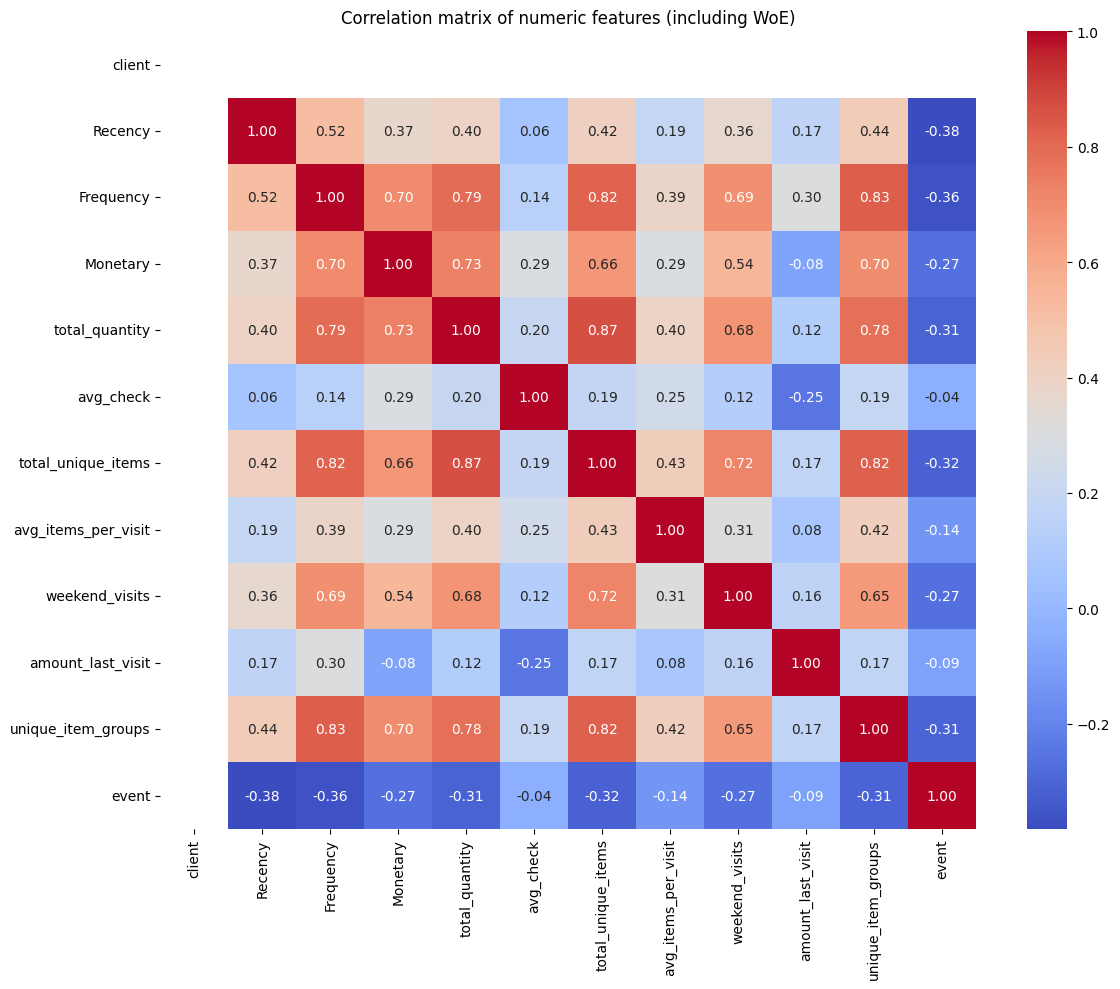

In [9]:
import seaborn as sns

# Выбираем только числовые колонки (float, int) для корреляции
numeric_cols = train_woe.select_dtypes(include=[np.number]).columns
print(f"Numeric columns for correlation: {list(numeric_cols)}")

# Вычисляем корреляционную матрицу
corr_matrix = train_woe[numeric_cols].corr()

# Визуализируем тепловую карту
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation matrix of numeric features (including WoE)")
plt.tight_layout()
plt.show()

Validation ROC-AUC: 0.8001

Top features by XGBoost importance:
Recency                0.518488
Frequency              0.297633
total_quantity         0.048258
total_unique_items     0.022116
avg_check              0.020173
weekend_visits         0.019940
avg_items_per_visit    0.019480
Monetary               0.018177
amount_last_visit      0.018017
unique_item_groups     0.017717
dtype: float32


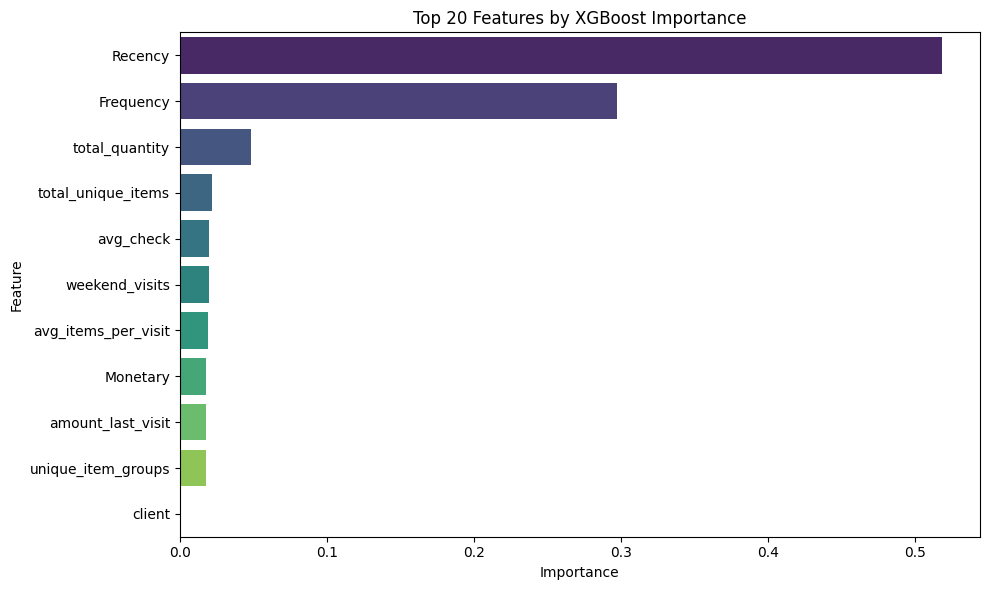

In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# 1️⃣ Определяем X и y
target = target_col  # ваш таргет
X = train_woe.drop(columns=[target])
y = train_woe[target]

# Только числовые признаки (WoE уже числовые)
X_numeric = X.select_dtypes(include=[np.number])

# 2️⃣ Разделяем на тренировку и валидацию
X_train, X_val, y_train, y_val = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42, stratify=y
)

# 3️⃣ Создаем модель XGBoost
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

# 4️⃣ Обучаем модель
model.fit(X_train, y_train)

# 5️⃣ Оценка на валидации
y_pred_proba = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)
print(f"Validation ROC-AUC: {auc:.4f}")

# 6️⃣ Важность признаков
importance = model.feature_importances_
feature_importance = pd.Series(importance, index=X_numeric.columns).sort_values(ascending=False)

print("\nTop features by XGBoost importance:")
print(feature_importance.head(10))

# 7️⃣ Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.head(20), y=feature_importance.head(20).index, palette="viridis")
plt.title("Top 20 Features by XGBoost Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Train ROC-AUC: 0.7753
Test ROC-AUC: 0.7721


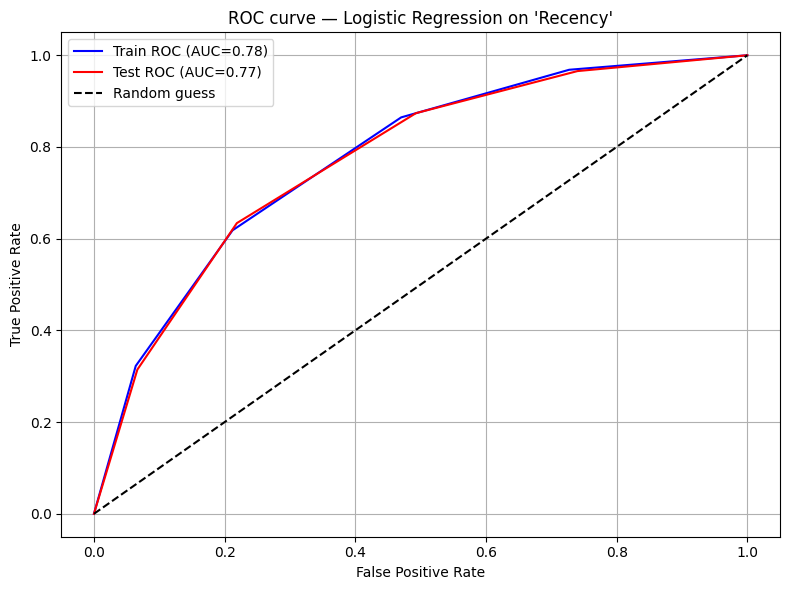

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# 1️⃣ Признак и таргет
feature = "Recency"  # колонка "Давность"
target = target_col

# Обучающая выборка
X_train = train_woe[[feature]]
y_train = train_woe[target]

# Тестовая выборка
X_test = test_woe[[feature]]
y_test = test_woe[target] if target in test_woe.columns else None

# 2️⃣ Логистическая регрессия
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# 3️⃣ Предсказания (вероятности)
y_train_pred_proba = logreg.predict_proba(X_train)[:, 1]
y_test_pred_proba  = logreg.predict_proba(X_test)[:, 1]

# 4️⃣ ROC-AUC
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print(f"Train ROC-AUC: {auc_train:.4f}")

if y_test is not None:
    auc_test = roc_auc_score(y_test, y_test_pred_proba)
    print(f"Test ROC-AUC: {auc_test:.4f}")

# 5️⃣ ROC-кривые
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
if y_test is not None:
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC={auc_train:.2f})", color='blue')
if y_test is not None:
    plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC={auc_test:.2f})", color='red')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve — Logistic Regression on '{feature}'")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Train ROC-AUC: 0.8072
Test ROC-AUC: 0.8012


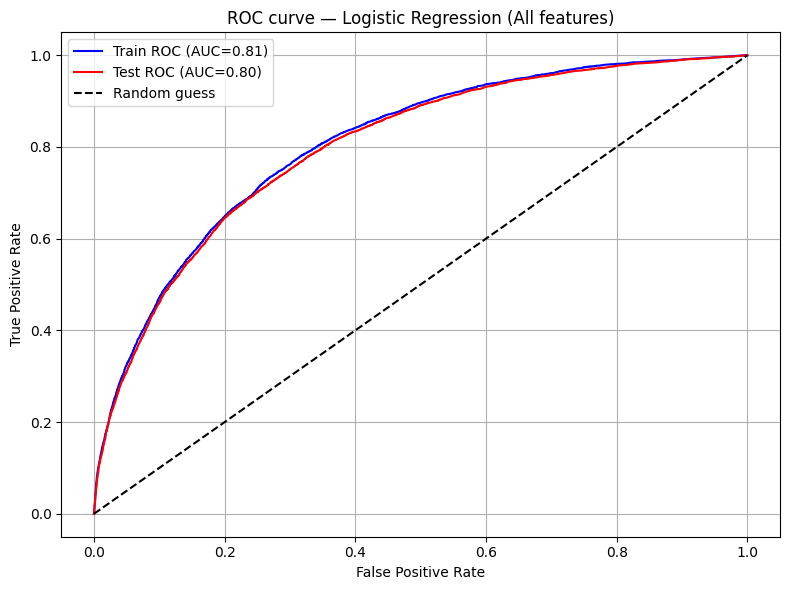

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1️⃣ Определяем X и y
target = target_col  # таргет
X_train = train_woe.drop(columns=[target])
y_train = train_woe[target]

X_test = test_woe.drop(columns=[target])
y_test = test_woe[target] if target in test_woe.columns else None

# Выбираем только числовые признаки (WoE уже числовые)
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test[X_train.columns]  # согласуем колонки

# 2️⃣ Обучаем логистическую регрессию
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# 3️⃣ Предсказания (вероятности)
y_train_pred_proba = logreg.predict_proba(X_train)[:, 1]
y_test_pred_proba  = logreg.predict_proba(X_test)[:, 1]

# 4️⃣ ROC-AUC
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print(f"Train ROC-AUC: {auc_train:.4f}")

if y_test is not None:
    auc_test = roc_auc_score(y_test, y_test_pred_proba)
    print(f"Test ROC-AUC: {auc_test:.4f}")

# 5️⃣ ROC-кривые
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
if y_test is not None:
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC={auc_train:.2f})", color='blue')
if y_test is not None:
    plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC={auc_test:.2f})", color='red')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve — Logistic Regression (All features)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


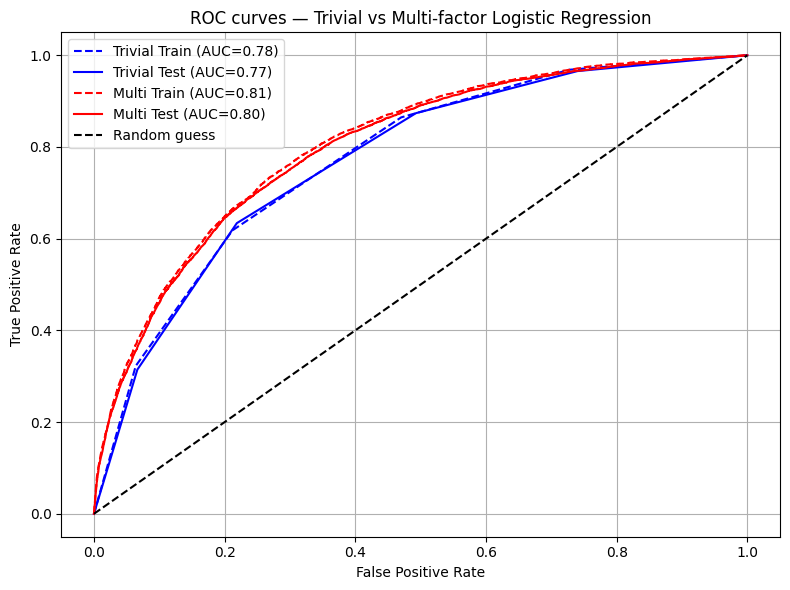

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Тривиальная модель (Recently)
# -----------------------------
X_trivial_train = train_woe[["Recency"]]
y_train = train_woe[target_col]
X_trivial_test = test_woe[["Recency"]]
y_test = test_woe[target_col] if target_col in test_woe.columns else None

# Логрегрессия
logreg_trivial = LogisticRegression()
logreg_trivial.fit(X_trivial_train, y_train)

# Предсказания
y_trivial_train_proba = logreg_trivial.predict_proba(X_trivial_train)[:, 1]
y_trivial_test_proba  = logreg_trivial.predict_proba(X_trivial_test)[:, 1]

# ROC-AUC
auc_trivial_train = roc_auc_score(y_train, y_trivial_train_proba)
auc_trivial_test = roc_auc_score(y_test, y_trivial_test_proba) if y_test is not None else None

# ROC кривые
fpr_trivial_train, tpr_trivial_train, _ = roc_curve(y_train, y_trivial_train_proba)
fpr_trivial_test, tpr_trivial_test, _ = roc_curve(y_test, y_trivial_test_proba) if y_test is not None else (None, None, None)

# -----------------------------
# 2️⃣ Многофакторная модель (все признаки)
# -----------------------------
X_multi_train = train_woe.drop(columns=[target_col]).select_dtypes(include=[np.number])
X_multi_test  = test_woe[X_multi_train.columns]  # согласуем колонки

logreg_multi = LogisticRegression(max_iter=1000)
logreg_multi.fit(X_multi_train, y_train)

# Предсказания
y_multi_train_proba = logreg_multi.predict_proba(X_multi_train)[:, 1]
y_multi_test_proba  = logreg_multi.predict_proba(X_multi_test)[:, 1]

# ROC-AUC
auc_multi_train = roc_auc_score(y_train, y_multi_train_proba)
auc_multi_test  = roc_auc_score(y_test, y_multi_test_proba) if y_test is not None else None

# ROC кривые
fpr_multi_train, tpr_multi_train, _ = roc_curve(y_train, y_multi_train_proba)
fpr_multi_test, tpr_multi_test, _ = roc_curve(y_test, y_multi_test_proba) if y_test is not None else (None, None, None)

# -----------------------------
# 3️⃣ Построение объединенного графика
# -----------------------------
plt.figure(figsize=(8, 6))

# Тривиальная модель
plt.plot(fpr_trivial_train, tpr_trivial_train, label=f"Trivial Train (AUC={auc_trivial_train:.2f})", color='blue', linestyle='--')
if y_test is not None:
    plt.plot(fpr_trivial_test, tpr_trivial_test, label=f"Trivial Test (AUC={auc_trivial_test:.2f})", color='blue')

# Многофакторная модель
plt.plot(fpr_multi_train, tpr_multi_train, label=f"Multi Train (AUC={auc_multi_train:.2f})", color='red', linestyle='--')
if y_test is not None:
    plt.plot(fpr_multi_test, tpr_multi_test, label=f"Multi Test (AUC={auc_multi_test:.2f})", color='red')

# Случайная модель
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves — Trivial vs Multi-factor Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ФИНАЛЬНЫЙ ЭТАП: ПРОГНОЗ НА СЛЕДУЮЩИЙ МЕСЯЦ
Дата построения профиля: 2019-10-01
Прогнозный период: с 2019-11-01 по 2019-12-01
Признаков для прогноза: 11
Клиентов для прогноза: 39906
⚠️ Лучшая модель не найдена, используем многофакторную логрегрессию

📈 СТАТИСТИКА ПРОГНОЗА:
Всего клиентов: 39906
Средняя вероятность возврата: 0.1894
Медианная вероятность возврата: 0.1308
Стандартное отклонение: 0.1771

Прогнозируемые классы:
  0: 36781 клиентов (92.2%)
  1: 3125 клиентов (7.8%)

🏆 ТОП-20 КЛИЕНТОВ С НАИБОЛЬШЕЙ ВЕРОЯТНОСТЬЮ ВОЗВРАТА:
 client  probability_return  predicted_class   Recency  Frequency  Monetary
  22180            0.764763                1 -1.617646  -1.878982 -0.569079
   3651            0.764608                1 -1.617646  -1.878982 -0.569079
  20222            0.762933                1 -1.617646  -1.878982 -0.569079
   5873            0.760529                1 -1.617646  -1.878982 -0.012577
  19884            0.758991                1 -1.617646  -1.878982 -0.012577
  39492 

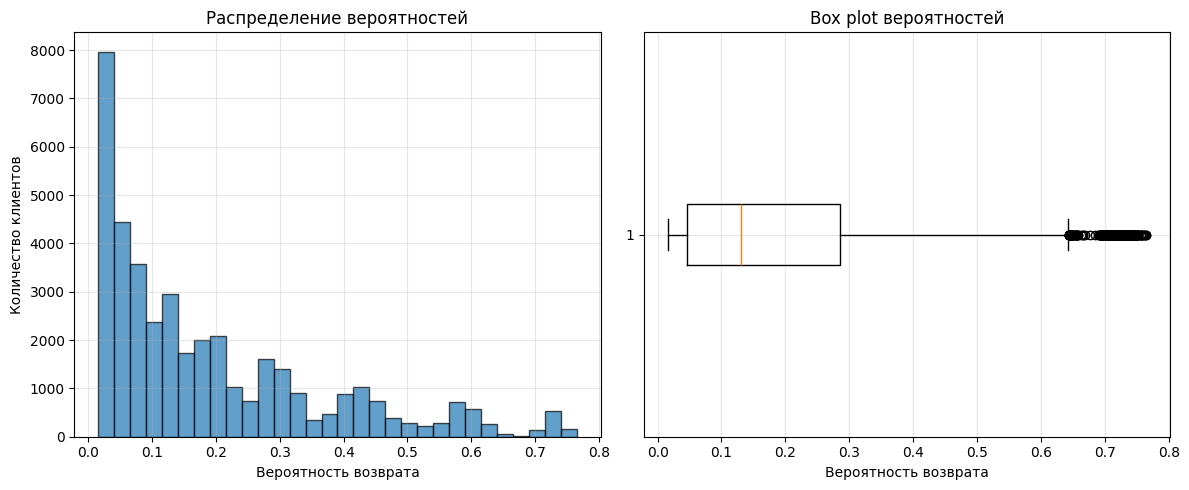


💾 Прогноз сохранен в 'results/forecast.csv'

Первые 5 строк сохраненного файла:
   client  probability_return  predicted_class   Recency  Frequency  Monetary
0   22180            0.764763                1 -1.617646  -1.878982 -0.569079
1    3651            0.764608                1 -1.617646  -1.878982 -0.569079
2   20222            0.762933                1 -1.617646  -1.878982 -0.569079
3    5873            0.760529                1 -1.617646  -1.878982 -0.012577
4   19884            0.758991                1 -1.617646  -1.878982 -0.012577


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

print("\n" + "=" * 70)
print("ФИНАЛЬНЫЙ ЭТАП: ПРОГНОЗ НА СЛЕДУЮЩИЙ МЕСЯЦ")
print("=" * 70)

# 1️⃣ Дата построения профиля (из TEST_CSV) и прогнозного периода
observation_date_for_forecast = '2019-10-01'
forecast_start_date = '2019-11-01'
forecast_end_date = '2019-12-01'

print(f"Дата построения профиля: {observation_date_for_forecast}")
print(f"Прогнозный период: с {forecast_start_date} по {forecast_end_date}")

# 2️⃣ Подготавливаем данные для прогноза
X_forecast = test_woe.copy()
if target_col in X_forecast.columns:
    X_forecast = X_forecast.drop(columns=[target_col])

# Оставляем только числовые признаки
X_forecast_numeric = X_forecast.select_dtypes(include=[np.number])

# Синхронизируем колонки с обучающей выборкой модели
X_forecast_aligned = X_forecast_numeric.reindex(columns=X_train.columns, fill_value=0)

print(f"Признаков для прогноза: {X_forecast_aligned.shape[1]}")
print(f"Клиентов для прогноза: {X_forecast_aligned.shape[0]}")

# 3️⃣ Загружаем лучшую модель (если есть)
try:
    with open("best_model.pkl", "rb") as f:
        best_model_loaded = pickle.load(f)
    print("✅ Лучшая модель успешно загружена")
    model_type = type(best_model_loaded).__name__
    print(f"Тип загруженной модели: {model_type}")
except FileNotFoundError:
    print("⚠️ Лучшая модель не найдена, используем многофакторную логрегрессию")
    best_model_loaded = logreg_multi
    model_type = type(best_model_loaded).__name__

# 4️⃣ Выполняем прогноз
forecast_probabilities = best_model_loaded.predict_proba(X_forecast_aligned)
if forecast_probabilities.shape[1] == 2:
    return_probabilities = forecast_probabilities[:, 1]
else:
    return_probabilities = forecast_probabilities
forecast_classes = best_model_loaded.predict(X_forecast_aligned)

# 5️⃣ Создаем итоговый DataFrame
forecast_results = pd.DataFrame({
    'client': test_woe.index if 'id' not in test_woe.columns else test_woe['id'],
    'probability_return': return_probabilities,
    'predicted_class': forecast_classes
})

# Добавляем ключевые признаки, если они есть
for col in ['Recency', 'Frequency', 'Monetary']:
    forecast_results[col] = X_forecast_aligned[col] if col in X_forecast_aligned.columns else 0

# 6️⃣ Сортировка по вероятности возврата
forecast_results_sorted = forecast_results.sort_values('probability_return', ascending=False).reset_index(drop=True)

# 7️⃣ Статистика прогноза
print(f"\n📈 СТАТИСТИКА ПРОГНОЗА:")
print(f"Всего клиентов: {len(forecast_results_sorted)}")
print(f"Средняя вероятность возврата: {forecast_results_sorted['probability_return'].mean():.4f}")
print(f"Медианная вероятность возврата: {forecast_results_sorted['probability_return'].median():.4f}")
print(f"Стандартное отклонение: {forecast_results_sorted['probability_return'].std():.4f}")

class_counts = forecast_results_sorted['predicted_class'].value_counts()
print(f"\nПрогнозируемые классы:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count} клиентов ({count / len(forecast_results_sorted) * 100:.1f}%)")

# 8️⃣ Показываем топ-20 клиентов
print(f"\n🏆 ТОП-20 КЛИЕНТОВ С НАИБОЛЬШЕЙ ВЕРОЯТНОСТЬЮ ВОЗВРАТА:")
top_20 = forecast_results_sorted.head(20)
print(top_20.to_string(index=False))

# 9️⃣ Визуализация распределения вероятностей
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(forecast_results_sorted['probability_return'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Вероятность возврата')
plt.ylabel('Количество клиентов')
plt.title('Распределение вероятностей')
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.boxplot(forecast_results_sorted['probability_return'], vert=False)
plt.xlabel('Вероятность возврата')
plt.title('Box plot вероятностей')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 10️⃣ Сохраняем прогноз
import os
os.makedirs('results', exist_ok=True)
forecast_results_sorted.to_csv('results/forecast.csv', index=False, encoding='utf-8-sig')
print("\n💾 Прогноз сохранен в 'results/forecast.csv'")

# 11️⃣ Проверка сохраненного файла
saved_forecast = pd.read_csv('results/forecast.csv', encoding='utf-8-sig')
print(f"\nПервые 5 строк сохраненного файла:")
print(saved_forecast.head())



In [23]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

# -----------------------------
# 1️⃣ Подготовка данных
# -----------------------------
target = target_col
X = train_woe.drop(columns=[target]).select_dtypes(include=[np.number])
y = train_woe[target]

# Разделяем на тренировку и валидацию
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 2️⃣ Обучение XGBoost
# -----------------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_val_pred_xgb = xgb_model.predict_proba(X_val)[:, 1]
auc_xgb = roc_auc_score(y_val, y_val_pred_xgb)
print(f"XGBoost ROC-AUC (val): {auc_xgb:.4f}")

# -----------------------------
# 3️⃣ Обучение многофакторной логрегрессии
# -----------------------------
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)
y_val_pred_logreg = logreg_model.predict_proba(X_val)[:, 1]
auc_logreg = roc_auc_score(y_val, y_val_pred_logreg)
print(f"Logistic Regression ROC-AUC (val): {auc_logreg:.4f}")

# -----------------------------
# 4️⃣ Выбор лучшей модели
# -----------------------------
if auc_xgb >= auc_logreg:
    best_model = xgb_model
    best_model_name = "XGBoost"
    best_auc = auc_xgb
else:
    best_model = logreg_model
    best_model_name = "Logistic Regression"
    best_auc = auc_logreg

print(f"\n✅ Лучшая модель: {best_model_name} (ROC-AUC={best_auc:.4f})")

# -----------------------------
# 5️⃣ Подготовка данных для прогноза
# -----------------------------
X_forecast = test_woe.copy()
if target_col in X_forecast.columns:
    X_forecast = X_forecast.drop(columns=[target_col])
X_forecast_numeric = X_forecast.select_dtypes(include=[np.number])
X_forecast_aligned = X_forecast_numeric.reindex(columns=X_train.columns, fill_value=0)

# -----------------------------
# 6️⃣ Прогноз
# -----------------------------
forecast_probabilities = best_model.predict_proba(X_forecast_aligned)
return_probabilities = forecast_probabilities[:, 1] if forecast_probabilities.shape[1] == 2 else forecast_probabilities
forecast_classes = best_model.predict(X_forecast_aligned)

# -----------------------------
# 7️⃣ Итоговый DataFrame с прогнозами
# -----------------------------
forecast_results = pd.DataFrame({
    'client': test_woe.index if 'id' not in test_woe.columns else test_woe['id'],
    'probability_return': return_probabilities,
    'predicted_class': forecast_classes
})

for col in ['Recency', 'Frequency', 'Monetary']:
    forecast_results[col] = X_forecast_aligned[col] if col in X_forecast_aligned.columns else 0

forecast_results_sorted = forecast_results.sort_values('probability_return', ascending=False).reset_index(drop=True)

# -----------------------------
# 8️⃣ Сохранение и вывод
# -----------------------------
os.makedirs('results', exist_ok=True)
forecast_results_sorted.to_csv('results/forecast.csv', index=False, encoding='utf-8-sig')
print(f"\n💾 Прогноз сохранен в 'results/forecast.csv'")
print(f"Всего прогнозируемых клиентов: {len(forecast_results_sorted)}")
print(f"Лучшая модель: {best_model_name} (ROC-AUC={best_auc:.4f})")
print("\nПервые 5 строк прогноза:")
print(forecast_results_sorted.head())

XGBoost ROC-AUC (val): 0.8001
Logistic Regression ROC-AUC (val): 0.8021

✅ Лучшая модель: Logistic Regression (ROC-AUC=0.8021)

💾 Прогноз сохранен в 'results/forecast.csv'
Всего прогнозируемых клиентов: 39906
Лучшая модель: Logistic Regression (ROC-AUC=0.8021)

Первые 5 строк прогноза:
   client  probability_return  predicted_class   Recency  Frequency  Monetary
0   22180            0.775857                1 -1.617646  -1.878982 -0.569079
1    3651            0.773841                1 -1.617646  -1.878982 -0.569079
2   20222            0.772958                1 -1.617646  -1.878982 -0.569079
3    5873            0.769027                1 -1.617646  -1.878982 -0.012577
4   39492            0.767022                1 -1.617646  -1.878982 -0.012577
